#Introduction

Nama  : Fitri Octaviani

Batch : HCK-006

# Objective

Membuat model klasifikasi menggunakan Logistic Regression dan SVM untuk memprediksi income bracket.

# SQL Query

```
SELECT age, workclass, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket
FROM `bigquery-public-data.ml_datasets.census_adult_income`
WHERE workclass NOT LIKE '%?%'
  AND hours_per_week <100
LIMIT 11994
```



# Import Library

In [1]:
!pip install feature_engine

In [2]:
# untuk korelasi yang bernilai string
!pip install phik

In [3]:
# import library yang dibutuhkan
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
import pandas as pd
import numpy  as np
import seaborn as sns; sns.set()
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix

# Data Loading

In [4]:
# Read dataset
df = pd.read_csv('/content/sample_data/h8dsft_P1G2_Fitri Octaviani.csv')

In [5]:
# menampilkan data teratas
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K


In [6]:
# menampilkan data terbawah
df.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
11989,34,Private,HS-grad,9,Separated,Handlers-cleaners,Not-in-family,White,Male,2463,0,40,United-States,<=50K
11990,43,Private,HS-grad,9,Separated,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
11991,29,Private,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
11992,51,Private,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,0,1876,40,United-States,<=50K
11993,57,Private,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,2174,0,40,Cuba,<=50K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994 entries, 0 to 11993
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             11994 non-null  int64 
 1   workclass       11994 non-null  object
 2   education       11994 non-null  object
 3   education_num   11994 non-null  int64 
 4   marital_status  11994 non-null  object
 5   occupation      11994 non-null  object
 6   relationship    11994 non-null  object
 7   race            11994 non-null  object
 8   sex             11994 non-null  object
 9   capital_gain    11994 non-null  int64 
 10  capital_loss    11994 non-null  int64 
 11  hours_per_week  11994 non-null  int64 
 12  native_country  11994 non-null  object
 13  income_bracket  11994 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.3+ MB


Terdapat 11994 entri data, sekilas tidak ada data missing value.

In [8]:
# menampilkan missing value
df.isnull().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

Tidak ada missing value

In [9]:
# cek duplikat data
df.duplicated().sum()

1583

Terdapat 1583 entri data yang duplikat

In [10]:
# drop data duplikat
df_no_dpl = df.drop_duplicates()

In [11]:
# cek jumlah duplikat data
df_no_dpl.duplicated().sum()

0

data duplikat sudah tidak ada

In [12]:
df_no_dpl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10411 entries, 0 to 11993
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10411 non-null  int64 
 1   workclass       10411 non-null  object
 2   education       10411 non-null  object
 3   education_num   10411 non-null  int64 
 4   marital_status  10411 non-null  object
 5   occupation      10411 non-null  object
 6   relationship    10411 non-null  object
 7   race            10411 non-null  object
 8   sex             10411 non-null  object
 9   capital_gain    10411 non-null  int64 
 10  capital_loss    10411 non-null  int64 
 11  hours_per_week  10411 non-null  int64 
 12  native_country  10411 non-null  object
 13  income_bracket  10411 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.2+ MB


In [13]:
# melihat list kolom yang memiliki nilai sebagai kategori
cat_cols = list(df.select_dtypes(include='object'))
cat_cols

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'income_bracket']

In [14]:
# categorical overview
df[cat_cols].describe()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income_bracket
count,11994,11994,11994,11994,11994,11994,11994,11994,11994
unique,8,8,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,9603,8215,6141,2332,5483,10014,8436,10578,10197


In [15]:
# categorical overview
for i in cat_cols:
    print('Column: ',i)
    print('Total unique labels: ', df[i].nunique())
    print('-' * 30)

Column:  workclass
Total unique labels:  8
------------------------------
Column:  education
Total unique labels:  8
------------------------------
Column:  marital_status
Total unique labels:  7
------------------------------
Column:  occupation
Total unique labels:  15
------------------------------
Column:  relationship
Total unique labels:  6
------------------------------
Column:  race
Total unique labels:  5
------------------------------
Column:  sex
Total unique labels:  2
------------------------------
Column:  native_country
Total unique labels:  41
------------------------------
Column:  income_bracket
Total unique labels:  2
------------------------------


In [16]:
# melihat list kolom yang memiliki nilai sebagai numerikal
num_cols = df.describe().columns.tolist()
num_cols

['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [17]:
# numeric overview
df[num_cols].describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,11994.000000,11994.000000,11994.000000,11994.000000,11994.000000
mean,39.032099,7.946306,516.900784,66.466400,39.863265
std,14.017138,1.805876,4657.523360,351.759874,11.885091
min,17.000000,2.000000,0.000000,0.000000,1.000000
25%,28.000000,7.000000,0.000000,0.000000,40.000000
50%,37.000000,9.000000,0.000000,0.000000,40.000000
75%,49.000000,9.000000,0.000000,0.000000,40.000000
max,90.000000,9.000000,99999.000000,4356.000000,99.000000


In [18]:
# numerical overview
for i in num_cols:
    print('Column: ',i)
    print('Total unique labels: ', df[i].nunique())
    print('-' * 30)

Column:  age
Total unique labels:  70
------------------------------
Column:  education_num
Total unique labels:  8
------------------------------
Column:  capital_gain
Total unique labels:  100
------------------------------
Column:  capital_loss
Total unique labels:  71
------------------------------
Column:  hours_per_week
Total unique labels:  89
------------------------------


# Exploratory Data Analysis

In [19]:
df_no_dpl.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K


In [20]:
num_col = df_no_dpl.select_dtypes('number').columns.to_list()
num_col

['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [21]:
cat_col = df_no_dpl.select_dtypes(exclude='number').columns.to_list()
cat_col

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'income_bracket']

In [22]:
df_no_dpl[num_col].describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,10411.000000,10411.000000,10411.000000,10411.000000,10411.000000
mean,39.645375,7.837095,595.495918,75.896936,40.035251
std,14.158200,1.877050,4994.436595,375.082194,12.390562
min,17.000000,2.000000,0.000000,0.000000,1.000000
25%,28.000000,7.000000,0.000000,0.000000,38.000000
50%,38.000000,9.000000,0.000000,0.000000,40.000000
75%,50.000000,9.000000,0.000000,0.000000,44.000000
max,90.000000,9.000000,99999.000000,4356.000000,99.000000


In [23]:
df_no_dpl[cat_col].describe()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income_bracket
count,10411,10411,10411,10411,10411,10411,10411,10411,10411
unique,8,8,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,8094,6837,5148,1779,4511,8491,7138,9005,8806


In [24]:
df_no_dpl['income_bracket'].unique()

array([' <=50K', ' >50K'], dtype=object)

## Feature Selection

interval columns not set, guessing: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


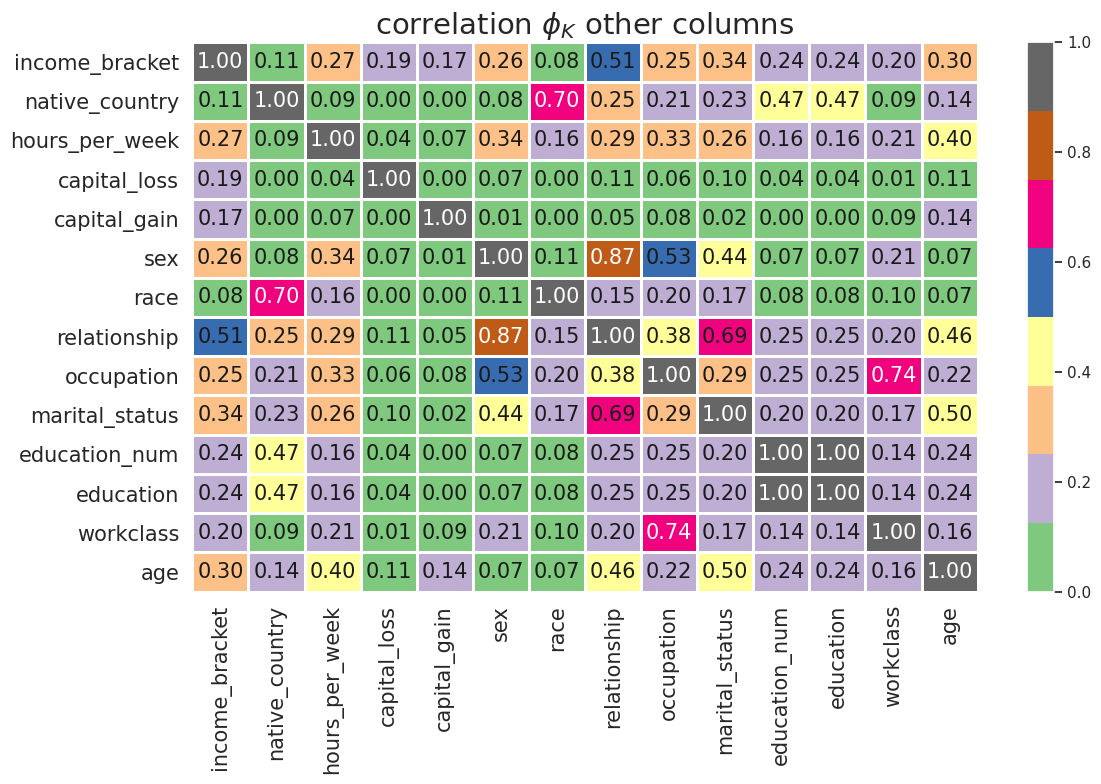

In [25]:
# get the phi_k correlation matrix
phik_matrix = df_no_dpl.phik_matrix()
plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map="Accent",
                        title=r"correlation $\phi_K$ other columns",
                        fontsize_factor=1.5,
                        figsize=(12,8))
plt.tight_layout()

In [26]:
# cek korelasi terhadap income_bracket
df_no_dpl.phik_matrix().income_bracket.sort_values(ascending=False)

interval columns not set, guessing: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


income_bracket    1.000000
relationship      0.505170
marital_status    0.337530
age               0.298610
hours_per_week    0.273658
sex               0.256805
occupation        0.253898
education         0.236765
education_num     0.236765
workclass         0.197222
capital_loss      0.186343
capital_gain      0.172411
native_country    0.109003
race              0.081005
Name: income_bracket, dtype: float64

Fitur yang berkorelasi paling kuat dengan target (income_bracket) adalah relationship

In [27]:
# drop fitur yang korelasi threshold nya > 0.20
dropped_features =['race','native_country', 'capital_gain', 'capital_loss', 'workclass']

In [28]:
# Cek antara kesamaan education dan education_num
df_no_dpl[['education','education_num']].value_counts()

education  education_num
 HS-grad   9                6837
 11th      7                 950
 10th      6                 783
 7th-8th   4                 558
 9th       5                 457
 12th      8                 374
 5th-6th   3                 298
 1st-4th   2                 154
dtype: int64

Sepertinya kolom education dan education_num adalah representasi numerik dari fitur education. Sehingga saya akan mendrop fitur education.

In [29]:
dropped_features.append('education')

In [30]:
df_no_dpl.drop(columns=dropped_features,inplace=True)

<ipython-input-30-a867eb232905>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_dpl.drop(columns=dropped_features,inplace=True)


In [31]:
#cek data duplikat setelah feature selection
df_no_dpl.duplicated().sum()

1406

In [32]:
# drop data duplikat
df_feature_selected = df_no_dpl.drop_duplicates()

In [33]:
# cek data duplikat
df_feature_selected.duplicated().sum()

0

In [34]:
# final
df_feature_selected.head()

,age,education_num,marital_status,occupation,relationship,sex,hours_per_week,income_bracket
0,39,5,Married-civ-spouse,Other-service,Wife,Female,34,<=50K
1,77,5,Married-civ-spouse,Priv-house-serv,Wife,Female,10,<=50K
2,38,5,Married-civ-spouse,Other-service,Wife,Female,24,<=50K
3,28,5,Married-civ-spouse,Protective-serv,Wife,Female,40,<=50K
4,37,5,Married-civ-spouse,Machine-op-inspct,Wife,Female,48,<=50K


# Data Preprocessing

## Train Test Split

In [35]:
#split antara fitur dan target
X = df_feature_selected.drop('income_bracket',axis=1)
y = df_feature_selected['income_bracket']

In [36]:
#split antara train dan test
X_train,X_test, y_train, y_test= train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)
print(f'train size: {X_train.shape}')
print(f'test size: {X_test.shape}')

train size: (7204, 7)
test size: (1801, 7)


In [37]:
# melihat data X_train
X_train.head()

,age,education_num,marital_status,occupation,relationship,sex,hours_per_week
2066,42,7,Separated,Other-service,Unmarried,Female,38
11582,48,9,Divorced,Machine-op-inspct,Not-in-family,Male,40
9328,21,9,Never-married,Prof-specialty,Own-child,Female,30
2057,27,7,Divorced,Machine-op-inspct,Unmarried,Female,40
10391,35,9,Divorced,Tech-support,Unmarried,Female,40


In [38]:
# melihat data y_train
y_train.head()

2066      <=50K
11582     <=50K
9328      <=50K
2057      <=50K
10391     <=50K
Name: income_bracket, dtype: object

In [39]:
# melihat numerikal kolom pada data X_train
num_col = X_train.columns[X_train.dtypes!='object'].to_list()
num_col

['age', 'education_num', 'hours_per_week']

In [40]:
# melihat kategorikal kolom pada data X_train
cat_col = X_train.columns[X_train.dtypes=='object'].to_list()
cat_col

['marital_status', 'occupation', 'relationship', 'sex']

## Handling outlier

In [41]:
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()

    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")

    plt.show()

    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
    elif df[col].skew() > 0.5:
        print("Columns '{}' right skewed".format(col))
    elif df[col].skew() < -0.5:
        print("Columns '{}' left skewed".format(col))


In [42]:
df_col = df[num_col].columns.tolist()
df_col

['age', 'education_num', 'hours_per_week']

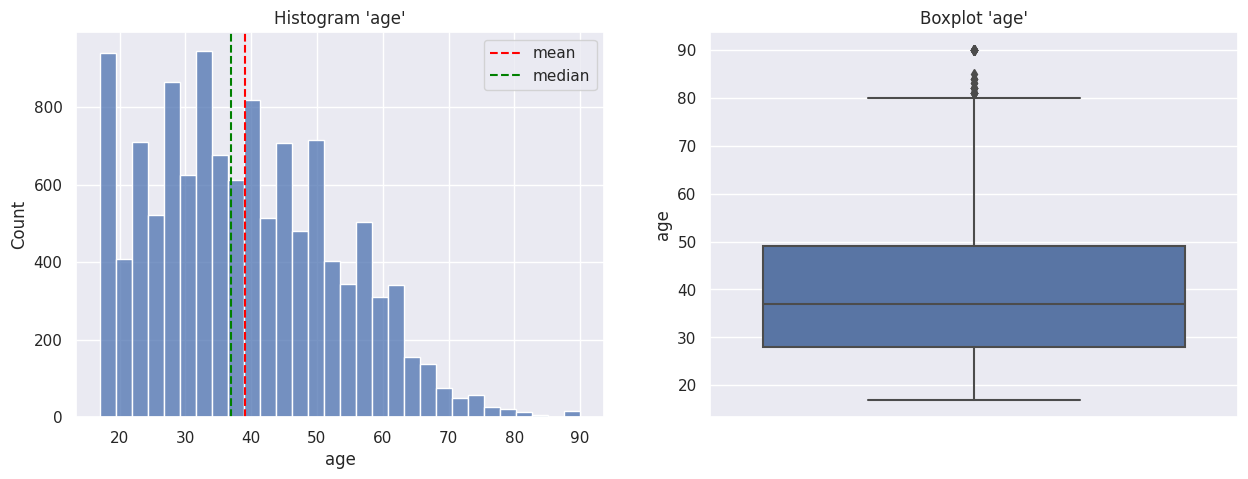

age Kurtosis: -0.42635571203781764
age Skewness: 0.4184672257425618
Columns 'age' normal distribution


In [43]:
plot_dist(df, df_col[0])

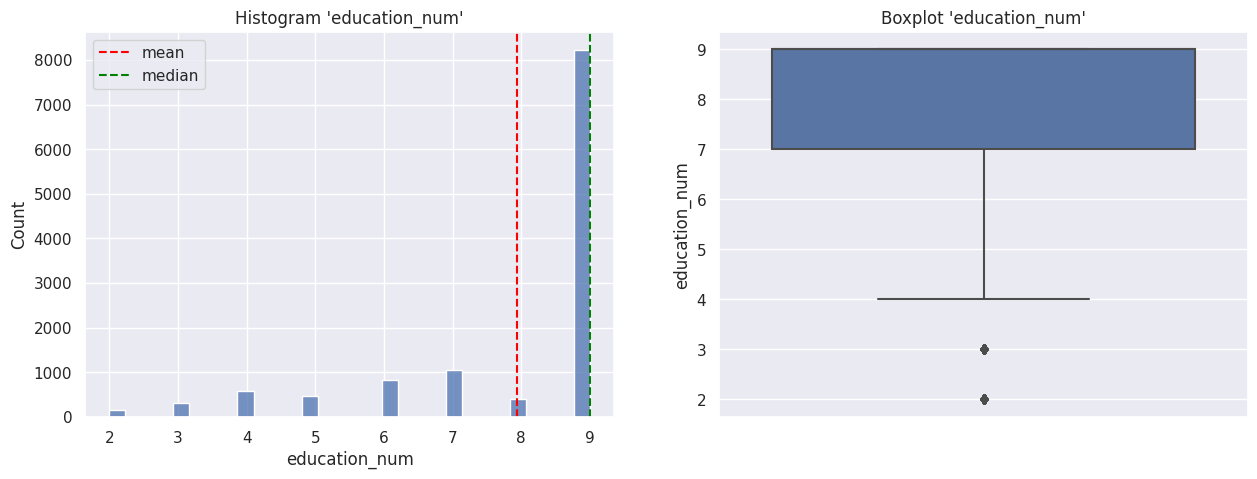

education_num Kurtosis: 1.4972731592604713
education_num Skewness: -1.6144764491827128
Columns 'education_num' left skewed


In [44]:
plot_dist(df, df_col[1])

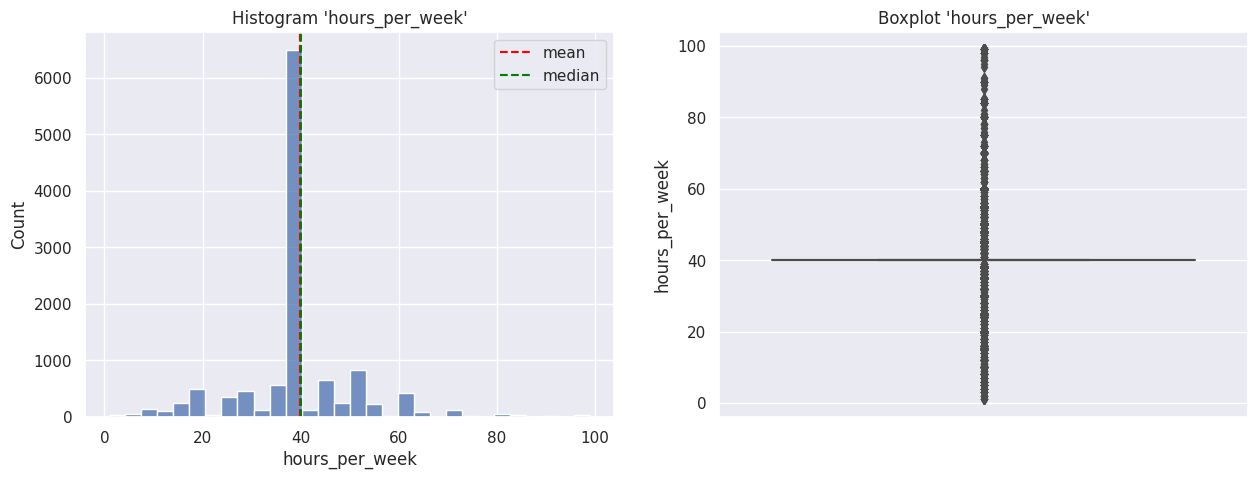

hours_per_week Kurtosis: 3.728405635152992
hours_per_week Skewness: 0.42137504514418495
Columns 'hours_per_week' normal distribution


In [45]:
plot_dist(df, df_col[2])

Pada grafik diatas terlihat bahwa outlier terdapat pada kolom age dan hours_per_week

In [46]:
# outlier detection using IQR
Q3 = X_train['age'].quantile(.75)
Q1 = X_train['age'].quantile(.25)

IQR = Q3 - Q1

upper = Q3 + (1.5 * IQR)
lower = Q1 - (1.5 * IQR)

outlier = X_train[(X_train['age'] > upper) | (X_train['age'] < lower)]

print('count of outlier age: ', outlier.shape[0])
print('percentage of outlier age: ', outlier.shape[0]/X_train.shape[0] * 100, '%')

count of outlier age:  17
percentage of outlier age:  0.2359800111049417 %


Outlier pada kolom age hanya mencapai 0.235 sehingga pada tahap ini dilakukan trimming

In [47]:
# drop/trimming outlier pada kolom age
outlier_age_index = X_train[(X_train['age'] <= upper) & (X_train['age'] >= lower)]
outlier_age_index.shape

(7187, 7)

In [48]:
# Compare before and after outlier handling
print('before handling: \n', X_train[num_col].describe())

print('after handling: \n', outlier_age_index[num_col].describe())

before handling: 
                age  education_num  hours_per_week
count  7204.000000    7204.000000     7204.000000
mean     39.859800       7.715852       40.082454
std      14.435802       1.937714       13.040795
min      17.000000       2.000000        1.000000
25%      28.000000       7.000000       36.000000
50%      38.000000       9.000000       40.000000
75%      50.000000       9.000000       45.000000
max      90.000000       9.000000       99.000000
after handling: 
                age  education_num  hours_per_week
count  7187.000000    7187.000000     7187.000000
mean     39.744400       7.716432       40.088493
std      14.255772       1.937519       13.023431
min      17.000000       2.000000        1.000000
25%      28.000000       7.000000       36.000000
50%      38.000000       9.000000       40.000000
75%      50.000000       9.000000       45.000000
max      83.000000       9.000000       99.000000


In [49]:
# outlier detection using IQR
Q3 = X_train['hours_per_week'].quantile(.75)
Q1 = X_train['hours_per_week'].quantile(.25)

IQR = Q3 - Q1

upper = Q3 + (1.5 * IQR)
lower = Q1 - (1.5 * IQR)

outlier = X_train[(X_train['hours_per_week'] > upper) | (X_train['hours_per_week'] < lower)]

print('count of outlier hours_per_week: ', outlier.shape[0])
print('percentage of outlier hours_per_week: ', outlier.shape[0]/X_train.shape[0] * 100, '%')

count of outlier hours_per_week:  1323
percentage of outlier hours_per_week:  18.364797334813993 %


Outlier pada kolom hours_per_week sangat tinggi hingga mencapai 18.364% sehingga untuk mengatasi outlier tersebut dilakukan secara censoring/capping.

In [50]:
# Create the capper
windsoriser = Winsorizer(capping_method='gaussian',
                          tail='both', # cap left, right or both tails
                          fold=1.5,
                          variables=['hours_per_week'])

windsoriser.fit(X_train)

X_train = windsoriser.transform(X_train)

Teknik censoring yang digunakan adalah winsorizing dengan metode capping gaussian karena fitur hours_per_week memiliki distribusi normal.

## Scaling

In [51]:
scaled_num_col = ['age','hours_per_week']
X_train[scaled_num_col]

,age,hours_per_week
2066,42,38.000000
11582,48,40.000000
9328,21,30.000000
2057,27,40.000000
10391,35,40.000000
...,...,...
760,52,35.000000
2855,29,20.522619
4928,26,40.000000
1241,50,50.000000


Untuk kolom numerikal, saya akan menggunakan scaling dengan MinMaxScaler

In [52]:
# instansiasi scaler
std_scaler= MinMaxScaler()

# stardardisasi data train
X_train[scaled_num_col]= std_scaler.fit_transform(X_train[scaled_num_col])
X_train[scaled_num_col].head(5)

,age,hours_per_week
2066,0.342466,0.446767
11582,0.424658,0.497892
9328,0.054795,0.242266
2057,0.136986,0.497892
10391,0.246575,0.497892


In [53]:
# melakukan stardardisasi data test
X_test[scaled_num_col]= std_scaler.transform(X_test[scaled_num_col])

## Encoding

In [54]:
# melihat categorical colom pada X_train
X_train[cat_col]

,marital_status,occupation,relationship,sex
2066,Separated,Other-service,Unmarried,Female
11582,Divorced,Machine-op-inspct,Not-in-family,Male
9328,Never-married,Prof-specialty,Own-child,Female
2057,Divorced,Machine-op-inspct,Unmarried,Female
10391,Divorced,Tech-support,Unmarried,Female
...,...,...,...,...
760,Married-civ-spouse,Craft-repair,Husband,Male
2855,Never-married,Other-service,Not-in-family,Male
4928,Married-civ-spouse,Transport-moving,Husband,Male
1241,Divorced,Sales,Not-in-family,Female


In [55]:
# melakukan onehotencoding
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = enc.fit_transform(X_train[cat_col])
X_train_ohe

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [56]:
# crosscheck data train sebelum di encode
X_train[cat_col].head(3)

,marital_status,occupation,relationship,sex
2066,Separated,Other-service,Unmarried,Female
11582,Divorced,Machine-op-inspct,Not-in-family,Male
9328,Never-married,Prof-specialty,Own-child,Female


In [57]:
# X_train setelah di encode
feature_names = enc.get_feature_names_out(input_features=cat_col)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=feature_names)
X_train_ohe.head(3)

,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [58]:
# crosscheck data train sebelum di encode
X_test[cat_col].head()

,marital_status,occupation,relationship,sex
4068,Married-civ-spouse,Exec-managerial,Wife,Female
3826,Married-civ-spouse,?,Wife,Female
8080,Married-civ-spouse,Transport-moving,Husband,Male
1969,Never-married,Sales,Own-child,Male
10973,Widowed,Other-service,Unmarried,Female


In [59]:
# onehotencoding untuk X_test
X_test_ohe = enc.transform(X_test[cat_col])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=feature_names)
X_test_ohe.head()

,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Concate Numerical

In [60]:
#reset index data X_train dan X_test sebelum di concat
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [61]:
#drop kolom categorical yang belum di encode pada X_train
X_train_num = X_train.drop(columns=cat_col)

#drop kolom categorical yang belum di encode pada X_test
X_test_num = X_test.drop(columns=cat_col)

In [62]:
# encod categorical pada X_train
X_train_final = pd.concat([X_train_num,X_train_ohe],axis=1)

# encod categorical pada X_test
X_test_final = pd.concat([X_test_num,X_test_ohe],axis=1)

In [63]:
 #melihat train final
 X_train_final.head()

,age,education_num,hours_per_week,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.342466,7,0.446767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.424658,9,0.497892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.054795,9,0.242266,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.136986,7,0.497892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.246575,9,0.497892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [64]:
#data test final tanpa outlier handling & transform only
X_test_final.head()

,age,education_num,hours_per_week,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.178082,9,0.497892,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.178082,9,0.497892,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.356164,9,0.625705,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.150685,7,0.497892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.863014,9,0.293392,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# Model

Model yang saya gunakan adalah logistic regression dan SVM.

In [65]:
# instansiasi model regresi logistik
log_model = LogisticRegression(max_iter=100000)

# instansiasi model SVR
svm_model = SVC(kernel="rbf", C=50)

## Model Training

Fit model logistic dan SVM terhadap data train

In [66]:
log_model.fit(X_train_final, y_train)

LogisticRegression(max_iter=100000)

In [67]:
svm_model.fit(X_train_final, y_train)

SVC(C=50)

## Model Evalusai

Model evaluasi dari performa model yang telah di train. Dengan pertimbangan data yang imbalance, upaya pencegahan imbalance dilakukan menggunakan stratify pada saat splitting data.

In [68]:
y_pred_train = log_model.predict(X_train_final)
y_pred_test = log_model.predict(X_test_final)

In [69]:
y_pred_train_svc = svm_model.predict(X_train_final)
y_pred_test_svc = svm_model.predict(X_test_final)

**LogisticRegression**

In [70]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

       <=50K       0.88      0.97      0.92      6163
        >50K       0.54      0.18      0.27      1041

    accuracy                           0.86      7204
   macro avg       0.71      0.58      0.60      7204
weighted avg       0.83      0.86      0.83      7204



Pada train-set, logistic regresi pada kelas income <=50k mendapatkan nilai F1-score sebesar 0.92 atau 92% yang tergolong baik. Akan tetapi, untuk kelas income >50k mendapatkan nilai F1-score yang rendah yaitu 0.28 atau 28% yang artinya model masih banyak memiliki prediksi yang kurang tepat atau bisa saja kategori income yang harusnya 50k malah digolongkan ke dalam kelas <=50.

In [71]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

       <=50K       0.87      0.96      0.91      1541
        >50K       0.39      0.15      0.21       260

    accuracy                           0.84      1801
   macro avg       0.63      0.55      0.56      1801
weighted avg       0.80      0.84      0.81      1801



Pada test set, logistic regresi pada kelas income <=50k mendapatkan F1-score sebesar 0.91 atau 91% yang tegolong baik. Akan tetapi, untuk kelas income >50k mendapatkan nilai F1-score yang rendah yaitu 0.23 atau 23%. Hal ini dapat disimpulkan untuk model banyak memiliki kesalahan prediksi untuk income >50k.

**SVM**

In [72]:
print(classification_report(y_train,y_pred_train_svc))

              precision    recall  f1-score   support

       <=50K       0.86      1.00      0.92      6163
        >50K       0.60      0.03      0.05      1041

    accuracy                           0.86      7204
   macro avg       0.73      0.51      0.49      7204
weighted avg       0.82      0.86      0.80      7204



Pada train-set, SVM pada kelas income <=50k mendapatkan nilai F1-score sebesar 0.92 atau 92% yang tergolong baik. Akan tetapi, untuk kelas income >50k mendapatkan nilai F1-score yang rendah yaitu 0.04 atau 4%.

In [73]:
print(classification_report(y_test,y_pred_test_svc))

              precision    recall  f1-score   support

       <=50K       0.86      1.00      0.92      1541
        >50K       0.00      0.00      0.00       260

    accuracy                           0.85      1801
   macro avg       0.43      0.50      0.46      1801
weighted avg       0.73      0.85      0.79      1801



Pada test set, SVM pada kelas income <=50k mendapatkan F1-score sebesar 0.92 atau 92% yang tegolong baik. Akan tetapi, untuk kelas income >50k mendapatkan nilai F1-score yang sangat rendah yaitu 0.0 atau 0%.

# Model Save

In [74]:
# save model
with open('model_log.pkl','wb') as file_1:
    joblib.dump(log_model,file_1)

with open('model_svc.pkl','wb') as file_2:
    joblib.dump(log_model,file_2)

with open('model_scaler.pkl','wb') as file_3:
    joblib.dump(std_scaler,file_3)

with open('model_encoder.pkl','wb') as file_4:
    joblib.dump(enc,file_4)

with open('num_cols.txt','wb') as file_5:
    joblib.dump(num_col,file_5)

with open('scaled_num_cols.txt','wb') as file_6:
    joblib.dump(scaled_num_col,file_6)

with open('cat_cols.txt','wb') as file_7:
    joblib.dump(cat_col,file_7)

# Conceptual Problems

1. Apakah yang dimaksud dengan coeficient pada logistic regression?
> Coeficient pada logistic regression adalah parameter yang menggambarkan pengaruh yang relatif dari setiap fitur terhadap target prediksi.

2. Apakah yang dimaksud dengan Support Vector pada SVM?
> Support Vector adalah subset dari sampel pelatihan yang berperan penting dalam menentukan posisi dan bentuk pembatasan keputusan (decision surface) yang optimal.

3. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!
> Parameter kernel pada SVM (Support Vector Machine) adalah parameter yang digunakan untuk memilih jenis fungsi kernel yang akan digunakan untuk mengubah ruang fitur asli menjadi ruang fitur yang lebih tinggi dimensi atau bahkan ruang tak terhingga. Contohnya Kernel RBF dimana mengubah ruang fitur menjadi ruang dimensi tak terhingga dengan memetakan setiap titik dalam ruang fitur ke fungsi basis radial.


# Kesimpulan

- Model yang digunakan adalah Logistic Regression dan SVM
- Dari kedua model tersebut, accuracy yang didapatkan tidak berbeda secara signifikan
- Hasil accuracy yang didapatkan untuk train dan test pada logistic regression itu baik hingga mencapai 0.86 atau 86% untuk train dan 0.84 atau 84% untuk test
- Hasil accuracy yang didapatkan untuk train dan test pada model svm bernilai baik hingga mencapai 0.86 atau 86% untuk train dan 0.86 atau 86% untuk test